# PREMIERS PAS EN PYTORCH

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import os.path
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch.nn as nn
import random
import time
import os
from torch.utils.tensorboard import SummaryWriter
import progressbar
import tqdm
import sys
from torch.utils.tensorboard import (
    SummaryWriter,
)  # dashboard local, dashboard en ligne permet de travailler à plusieurs

## Datasets

### Loading the data FashionMNIST

In [2]:
dataset_dir = os.path.join(os.path.expanduser("~"), "Datasets", "FashionMNIST")
valid_ratio = 0.2  # Going to use 80%/20% split for train/valid

# Load the dataset for the training/validation sets
train_valid_dataset = torchvision.datasets.FashionMNIST(
    root=dataset_dir,
    train=True,
    transform=None,  # transforms.ToTensor(),
    download=True,
)

# Split it into training and validation sets
nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
nb_valid = int(valid_ratio * len(train_valid_dataset))
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(
    train_valid_dataset, [nb_train, nb_valid]
)


# Load the test set
test_dataset = torchvision.datasets.FashionMNIST(
    root=dataset_dir, transform=None, train=False  # transforms.ToTensor(),
)

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Données convertir en tensor
tensor : mémoire RAM cpu / gpu d'ou le .to(device), qui l'envoie sur le la ram du device

tenseur : nom plus général pour matrice de dimension n

DatasetTransformer est une classe qui prends un Dataset et une fonction qui permet de transformer une donnée dans le type voulu. 

get_item retourne l'item dans le type voulu

In [3]:
class DatasetTransformer(torch.utils.data.Dataset):

    def __init__(self, base_dataset, transform):
        self.base_dataset = base_dataset
        self.transform = transform

    def __getitem__(self, index):
        img, target = self.base_dataset[index]
        return self.transform(img), target

    def __len__(self):
        return len(self.base_dataset)

In [4]:
train_dataset = DatasetTransformer(train_dataset, transforms.ToTensor())
valid_dataset = DatasetTransformer(valid_dataset, transforms.ToTensor())
test_dataset = DatasetTransformer(test_dataset, transforms.ToTensor())

### création des Dataloaders pour les 3 parties de notre base de donnée

train, test, validation grâce à DataLoader de pytorch. c'est ici qu'on choisi stocastique mini-bacth batch

In [5]:
num_threads = 4  # Loading the dataset is using 4 CPU threads
batch_size = 128  # Using minibatches of 128 samples si le dernier mini_batch <128, c'est pas grave, ca fait un mini_batch petit. Faire attention dans le training ( voir % accuracy)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,  # <-- this reshuffles the data at every epoch
    num_workers=num_threads,
)

valid_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_threads
)


test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_threads
)

On teste si les données sont bien loader. ensuite on affiche quelques images de plusieurs classe de notre dataset train

In [6]:
print(
    "The train set contains {} images, in {} batches".format(
        len(train_loader.dataset), len(train_loader)
    )
)
print(
    "The validation set contains {} images, in {} batches".format(
        len(valid_loader.dataset), len(valid_loader)
    )
)
print(
    "The test set contains {} images, in {} batches".format(
        len(test_loader.dataset), len(test_loader)
    )
)

The train set contains 48000 images, in 375 batches
The validation set contains 12000 images, in 94 batches
The test set contains 10000 images, in 79 batches


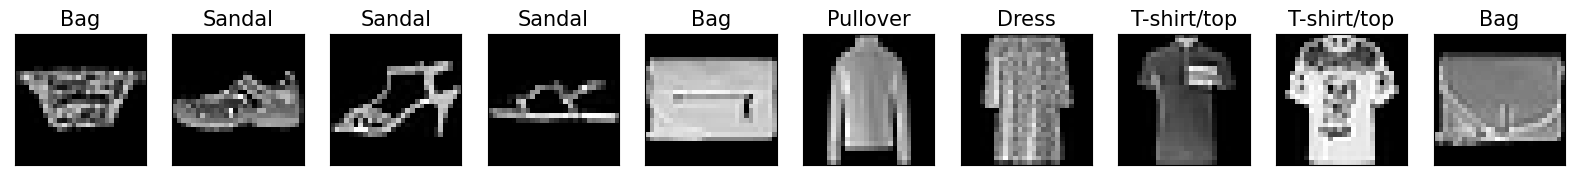

In [7]:
nsamples = 10
classes_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
imgs, labels = next(iter(train_loader))

fig = plt.figure(figsize=(20, 5), facecolor="w")
for i in range(nsamples):
    ax = plt.subplot(1, nsamples, i + 1)
    plt.imshow(imgs[i, 0, :, :], vmin=0, vmax=1.0, cmap=cm.gray)
    ax.set_title("{}".format(classes_names[labels[i]]), fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.savefig("fashionMNIST_samples.png", bbox_inches="tight")
plt.show()

## Linear Classifier

### construction du modèle linear classifier

linearNet, une couche linéaire de taille input_size,num_classes. 

Initialisation des weight and biais de tensor : eights and biases are initialized with a uniform distribution : uniform(-1/sqrt(in_features), 1/sqrt(in_features)).
In_features : linar(in_feat,out_feat)


(Batch, channel, Height, width) (torch mais attention (channel,h,w,batch)).

linear couche (\*, data) -> (\*, data) il prend en compte la dernière dimension du tensor (x.size()[0] ou x.shape[0] -1 plus modulable si tensor taille 1,2,3,...)

In [8]:
class LinearNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LinearNet, self).__init__()
        self.input_size = input_size
        self.classifier = nn.Linear(self.input_size, num_classes)

    def forward(self, x):
        x = x.view(
            x.size()[0], -1
        )  # voir markdown au dessus ! nb_images,image_size*channel en vect
        y = self.classifier(x)
        return y

ALTERNATIVE POUR ne pas faire de classe pour le réseau de neuronnes // tensorflow exemple :

**model = nn.Sequential(nn.Linear(2, 2), nn.Linear(2, 2))**

ALTERNATIVE POUR initialiser les poids à la main : 

**model.apply(init_weights)**

Ici on accède via cuda aux GPU dédiés, si il y en a pas, cpu. Ca permet d'envoyer les tensor sur le device.

In [9]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [10]:
model = LinearNet(1 * 28 * 28, 10)
model.to(device)

LinearNet(
  (classifier): Linear(in_features=784, out_features=10, bias=True)
)

### Training Test Validation

#### traning loop 



enumerate dans la boucle for utile pour récuperer les éléments et l'indice de range(len(M))

In [11]:
def train(model, loader, f_loss, optimizer, device):
    """
    Train a model for one epoch, iterating over the loader
    using the f_loss to compute the loss and the optimizer
    to update the parameters of the model.

    Arguments :

        model     -- A torch.nn.Module object
        loader    -- A torch.utils.data.DataLoader
        f_loss    -- The loss function, i.e. a loss Module
        optimizer -- A torch.optim.Optimzer object
        device    -- a torch.device class specifying the device
                     used for computation

    Returns :
    """

    # We enter train mode. This is useless for the linear model
    # but is important for layers such as dropout, batchnorm, ...
    # dropout mask de 0 ou 1 pour eviter l'overfitting x <- x* mask
    model.train()
    # with tqdm.tqdm(loader, unit="batch") as tepoch:
    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Compute the forward pass through the network up to the loss
        outputs = model(inputs)
        loss = f_loss(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # val_loss, val_acc = test(model, valid_loader, f_loss, device)
        # tepoch.set_postfix(loss = val_loss, accuracy=100. * val_acc)

cross entropy => Yk score de dim (nb pixels +1 (biais) ) Z = softmax(ji) in [0,9] zk = exp(yk)/sum(exp(yi))

Loss_cross =  -log(Zy_i)

pas de softmax layer, exp facilement trop grand. pytorch = MLL o softmax

LogSumExpTrick pour stabilité numérique: 

 zk = exp(yk - max(yi))/sum(exp(yi)- max(yj)) |
Loss_cross = yk -c  -log(sum(exp(yi)- max(yj)))

ici pas de one hot encoding, classes de 0 à 9

pour récup des probas a la main, softmax

In [12]:
f_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

#### test loop

In [13]:
def test(model, loader, f_loss, device):
    """
    Test a model by iterating over the loader

    Arguments :

        model     -- A torch.nn.Module object
        loader    -- A torch.utils.data.DataLoader
        f_loss    -- The loss function, i.e. a loss Module
        device    -- The device to use for computation

    Returns :

        A tuple with the mean loss and mean accuracy

    """
    # We disable gradient computation which speeds up the computation
    # and reduces the memory usage
    with torch.no_grad():
        # We enter evaluation mode. This is useless for the linear model
        # but is important with layers such as dropout, batchnorm, ..
        model.eval()
        N = 0
        tot_loss, correct = 0.0, 0.0
        for i, (inputs, targets) in enumerate(loader):

            # We got a minibatch from the loader within inputs and targets
            # With a mini batch size of 128, we have the following shapes
            #    inputs is of shape (128, 1, 28, 28)
            #    targets is of shape (128)

            # We need to copy the data on the GPU if we use one
            inputs, targets = inputs.to(device), targets.to(device)

            # Compute the forward pass, i.e. the scores for each input image
            outputs = model(inputs)

            # We accumulate the exact number of processed samples
            N += inputs.shape[0]

            # We accumulate the loss considering
            # The multipliation by inputs.shape[0] is due to the fact
            # that our loss criterion is averaging over its samples
            tot_loss += inputs.shape[0] * f_loss(outputs, targets).item()

            # For the accuracy, we compute the labels for each input image
            # Be carefull, the model is outputing scores and not the probabilities
            # But given the softmax is not altering the rank of its input scores
            # we can compute the label by argmaxing directly the scores
            predicted_targets = outputs.argmax(dim=1)
            correct += (predicted_targets == targets).sum().item()
        return tot_loss / N, correct / N

### execution

In [14]:
epochs = 30

for epoch in range(epochs):
    print("Epoch {}".format(epoch))
    train(model, train_loader, f_loss, optimizer, device)
    val_loss, val_acc = test(model, valid_loader, f_loss, device)
    print(" Validation : Loss : {:.4f}, Acc : {:.4f}".format(val_loss, val_acc))

Epoch 0
 Validation : Loss : 0.5743, Acc : 0.8131
Epoch 1
 Validation : Loss : 0.5137, Acc : 0.8295
Epoch 2
 Validation : Loss : 0.4847, Acc : 0.8378
Epoch 3
 Validation : Loss : 0.4670, Acc : 0.8438
Epoch 4
 Validation : Loss : 0.4558, Acc : 0.8467
Epoch 5
 Validation : Loss : 0.4471, Acc : 0.8489
Epoch 6
 Validation : Loss : 0.4450, Acc : 0.8492
Epoch 7
 Validation : Loss : 0.4369, Acc : 0.8522
Epoch 8
 Validation : Loss : 0.4300, Acc : 0.8551
Epoch 9
 Validation : Loss : 0.4298, Acc : 0.8537
Epoch 10
 Validation : Loss : 0.4279, Acc : 0.8532
Epoch 11
 Validation : Loss : 0.4228, Acc : 0.8558
Epoch 12
 Validation : Loss : 0.4230, Acc : 0.8553
Epoch 13
 Validation : Loss : 0.4222, Acc : 0.8562
Epoch 14
 Validation : Loss : 0.4258, Acc : 0.8542
Epoch 15
 Validation : Loss : 0.4220, Acc : 0.8551
Epoch 16
 Validation : Loss : 0.4237, Acc : 0.8543
Epoch 17
 Validation : Loss : 0.4219, Acc : 0.8576
Epoch 18
 Validation : Loss : 0.4232, Acc : 0.8548
Epoch 19
 Validation : Loss : 0.4174, Acc

## Sauvegarder un modèle 

In [15]:
def generate_unique_logpath(logdir, raw_run_name):
    i = 0
    while True:
        run_name = raw_run_name + "_" + str(i)
        log_path = os.path.join(logdir, run_name)
        if not os.path.isdir(log_path):
            return log_path
        i = i + 1


###################################################
# Example usage :
# 1- create the directory "./logs" if it does not exist
top_logdir = "./logs"
if not os.path.exists(top_logdir):
    os.mkdir(top_logdir)

# 2- We test the function by calling several times our function
logdir = generate_unique_logpath(top_logdir, "linear")
print("Logging to {}".format(logdir))
# -> Prints out     Logging to   ./logs/linear_0
if not os.path.exists(logdir):
    os.mkdir(logdir)

logdir = generate_unique_logpath(top_logdir, "linear")
print("Logging to {}".format(logdir))
# -> Prints out     Logging to   ./logs/linear_1
if not os.path.exists(logdir):
    os.mkdir(logdir)

Logging to ./logs/linear_8
Logging to ./logs/linear_9


In [16]:
class ModelCheckpoint:

    def __init__(self, filepath, model):
        self.min_loss = None
        self.filepath = filepath
        self.model = model

    def update(self, loss):
        if (self.min_loss is None) or (loss < self.min_loss):
            print("Saving a better model")
            torch.save(self.model.state_dict(), self.filepath)
            # torch.save(self.model, self.filepath)
            self.min_loss = loss

Ajout de la sauvegarde du modèle. on garde le meilleur modèle en fonction du corpus de validation.

In [17]:
###########################################
# Example usage

# on sauvegarde le modèle le meilleur vis à vis de tests
# Define the callback object

## refaire avec un modèle nouveau :
model = LinearNet(1 * 28 * 28, 10)
model.to(device)
## ouvrir un modèle sauvegarder avec torch.save
model_path = "logs/linear_1/best_model.pt"
print(model.load_state_dict(torch.load(model_path)))
# Switch to eval mode sinon les poids ne s'accualisent pas
model.eval()
optimizer = torch.optim.Adam(
    model.parameters()
)  ## ATTENTION A METTRE LE BON MODÈLE SI ON RÉINSTANCIE LE MODÈLE !

model_checkpoint = ModelCheckpoint(logdir + "/best_model.pt", model)

epochs = 10

for epoch in range(epochs):
    print("Epoch {}".format(epoch))
    train(model, train_loader, f_loss, optimizer, device)
    val_loss, val_acc = test(model, valid_loader, f_loss, device)
    print(" Validation : Loss : {:.4f}, Acc : {:.4f}".format(val_loss, val_acc))
    model_checkpoint.update(val_loss)

<All keys matched successfully>
Epoch 0
 Validation : Loss : 0.5753, Acc : 0.8130
Saving a better model
Epoch 1
 Validation : Loss : 0.5089, Acc : 0.8290
Saving a better model
Epoch 2
 Validation : Loss : 0.4929, Acc : 0.8338
Saving a better model
Epoch 3
 Validation : Loss : 0.4656, Acc : 0.8440
Saving a better model
Epoch 4
 Validation : Loss : 0.4564, Acc : 0.8446
Saving a better model
Epoch 5
 Validation : Loss : 0.4493, Acc : 0.8487
Saving a better model
Epoch 6
 Validation : Loss : 0.4414, Acc : 0.8528
Saving a better model
Epoch 7
 Validation : Loss : 0.4364, Acc : 0.8529
Saving a better model
Epoch 8
 Validation : Loss : 0.4314, Acc : 0.8546
Saving a better model
Epoch 9
 Validation : Loss : 0.4285, Acc : 0.8552
Saving a better model


#### Création et Sauvegarde des données autres (texte, tensorboard)

même boucle, on rajoute le tensorboard pour avoir des graphiques de notre loss et accuracy.

In [30]:
epochs = 10

model = LinearNet(1 * 28 * 28, 10)
model.to(device)
tensorboard_writer = SummaryWriter(log_dir=logdir)
## ouvrir un modèle sauvegarder avec torch.save
model_path = "logs/linear_1/best_model.pt"
print(model.load_state_dict(torch.load(model_path)))
# Switch to eval mode sinon les poids ne s'accualisent pas
model.eval()
optimizer = torch.optim.Adam(
    model.parameters()
)  ## ATTENTION A METTRE LE BON MODÈLE SI ON RÉINSTANCIE LE MODÈLE !

model_checkpoint = ModelCheckpoint(logdir + "/best_model.pt", model)
for epoch in range(epochs):
    print("Epoch {}".format(epoch))
    train(model, train_loader, f_loss, optimizer, device)
    train_loss, train_acc = test(model, train_loader, f_loss, device)
    val_loss, val_acc = test(model, valid_loader, f_loss, device)
    print(" Validation : Loss : {:.4f}, Acc : {:.4f}".format(val_loss, val_acc))
    model_checkpoint.update(val_loss)
    tensorboard_writer.add_scalar("metrics/train_loss", train_loss, epoch)
    tensorboard_writer.add_scalar("metrics/train_acc", train_acc, epoch)
    tensorboard_writer.add_scalar("metrics/val_loss", val_loss, epoch)
    tensorboard_writer.add_scalar("metrics/val_acc", val_acc, epoch)

<All keys matched successfully>
Epoch 0
 Validation : Loss : 0.5701, Acc : 0.8168
Saving a better model
Epoch 1
 Validation : Loss : 0.5095, Acc : 0.8319
Saving a better model
Epoch 2
 Validation : Loss : 0.4805, Acc : 0.8407
Saving a better model
Epoch 3
 Validation : Loss : 0.4655, Acc : 0.8448
Saving a better model
Epoch 4
 Validation : Loss : 0.4539, Acc : 0.8470
Saving a better model
Epoch 5
 Validation : Loss : 0.4488, Acc : 0.8504
Saving a better model
Epoch 6
 Validation : Loss : 0.4440, Acc : 0.8502
Saving a better model
Epoch 7
 Validation : Loss : 0.4394, Acc : 0.8505
Saving a better model
Epoch 8
 Validation : Loss : 0.4324, Acc : 0.8551
Saving a better model
Epoch 9
 Validation : Loss : 0.4328, Acc : 0.8537


Ensuite on sauvegarde le tensorboard pour le garder.

Normalement, hors jupyter notebook, tout ce relance d'un coup donc il y a un nouveau dossier log a chaque execution. 

COMMANDE DE VISUALISATION : tensorboard --logdir ./logs

In [20]:
summary_file = open(logdir + "/summary.txt", "w")
summary_text = """

Executed command
================
{}

Dataset
=======
FashionMNIST

Model summary
=============
{}

{} trainable parameters

Optimizer
========
{}

""".format(
    " ".join(sys.argv),
    model,
    sum(p.numel() for p in model.parameters() if p.requires_grad),
    optimizer,
)
summary_file.write(summary_text)
summary_file.close()


tensorboard_writer.add_text("Experiment summary", summary_text)

## Pre-processing

### normalisation des données

première étape : définir la fonction qui permet de normaliser. Elle n'existe pas dans Torch contrairement à d'autres librairies.

Torch utilise un transformer, qui transforme les données selon une fonction. (transformer est général)

Si problème convexe, une seul solutions, mais avec les differents lancements où dirait qu'il y a plusieurs minimum global : 
il est possible que nom standardisation fait que l'apprentissage n'est pas égal. a sauvegarder aussi les pré-processing.

In [26]:
def compute_mean_std(loader):
    # Compute the mean over minibatches
    mean_img = None
    for imgs, _ in loader:
        if mean_img is None:
            mean_img = torch.zeros_like(imgs[0])
        mean_img += imgs.sum(dim=0)
    mean_img /= len(loader.dataset)

    # Compute the std over minibatches
    std_img = torch.zeros_like(mean_img)
    for imgs, _ in loader:
        std_img += ((imgs - mean_img) ** 2).sum(dim=0)
    std_img /= len(loader.dataset)
    std_img = torch.sqrt(std_img)

    # Set the variance of pixels with no variance to 1
    # Because there is no variance
    # these pixels will anyway have no impact on the final decision
    std_img[std_img == 0] = 1

    return mean_img, std_img

transformation des données avec transforms.Compose : 

on récupère la moyenne et la variance sur TRAIN uniquement ! Eviter biais

In [28]:
normalizing_dataset = train_dataset
normalizing_loader = torch.utils.data.DataLoader(
    dataset=normalizing_dataset, batch_size=batch_size, num_workers=num_threads
)

# Compute mean and variance from the training set
mean_train_tensor, std_train_tensor = compute_mean_std(normalizing_loader)


data_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x - mean_train_tensor) / std_train_tensor),
    ]
)

train_dataset = DatasetTransformer(train_dataset, data_transforms)
valid_dataset = DatasetTransformer(valid_dataset, data_transforms)
test_dataset = DatasetTransformer(test_dataset, data_transforms)

## A Fully connected 2 hidden layers classifier
voir le fichier : 
2_layer_model.py pour voir A Fully connected 2 hidden layers classifier. 

commentaires ici et sur le .py

## sur la régularisation

idée : eviter le surapprentissage. Comment ?

- sur les données : 
    -data augmentation
    - new datasets

- sur le modèle :
    - coefficient d'apprentissage qui prennent en compte le poids du noeud  (L2 régularisation par exemple)
    - batch normalisation (normalise xi, en entre // data normalisation, ou dans le modèle n'importe ou)
    - dropout 

## envoyer en file sur DCE les entrainement en parallèle

exemple usage -> starting batch trainins in NN

node always 1 prod long = 48h / prod nuit = 12h //permet aussi de faire 4 jobs pas user plutot que 1.

array = combien de lancement

interet de la version avec git : choisir la version de code a tester pour pouvoir continuer à coder sans soucis.

avec copie du git et checkout la bonne version. requirements.txt pour faire un pip env spécifique.

ssh 2023avr_5@dce.metz.centrale.supelec.fr 

ssh 2023avr_5@chome.metz.supelec.fr

password : SingletonsGarrisonsRoguishly

argparse pour les parametres tuto dedans

byobu

squeue (voir jobs)
scancel 